In [1]:
import numpy as np
from scipy.stats import truncnorm, norm, binom
import matplotlib.pyplot as plt
import random

In [2]:
cutoff = 0.95

In [3]:
class Wafer:
    pass

In [4]:
class SolarCell:
    def __init__(self, working):
        self.working = working

In [64]:
class Machine:
    runtime = 0  #In Minutes
    costs = 0
    
    def __init__(self, p):  #Constructor
        """Make machine with probability p of turning a wafer into a working cell."""
        self.p = p
    
    def deposit(self, wafer):
        """Deposit a Wafer, returns a SolarCell"""
        self.runtime += 9    #9 minutes per deposition per wafer
        self.costs += 2 + 87/35  #It costs €2 to do a deposition. Wafers have a base cost of €87, but can be re-used 35 times
        working = random.random() < self.p 
        
        return SolarCell(working)
    
    def diagnosis(self, cell):
        """Diagnose a SolarCell, returns whether the cell works"""
        self.runtime += 2 if cell.working else 3  # Diagnosis costs 2 minutes if the created cell works, 3 minutes otherwise
        return cell.working
    
    def test_basic(self, n):
        """Test the machine n times and return the ratio of working cells"""
        wafers = n * [Wafer()] # Create list of n Wafer() objects
        cells = list(map(self.deposit, wafers)) # Deposit all wafers
        working_cells = list(filter(self.diagnosis, cells)) # Make list of working cells
        return len(working_cells)/len(cells) # Determine ratio of the amount of working cells and total cells 
    
    def get_stats(self):
        """Pretty print the status of machine."""
        days = self.runtime // (24 * 60)
        hours = (self.runtime % (24 * 60)) // 60
        minutes = (self.runtime % (24 * 60)) % 60
        rcosts = round(self.costs, 2)
        
        print("Actual accuracy of machine:", self.p)
        print("It takes", days, "day(s),", hours, "hour(s) and", minutes, "minute(s) to test.")
        print("The costs associated with this test method is €" + str(rcosts))
        
    def reset(self):
        """Reset the machine."""
        self.runtime = 0
        self.costs = 0
        
    def plot_basic(self, n):
        """Plot the probability of each estimation of p resulting from n tests."""
        fig, ax = plt.subplots(1, 1)
        x = np.arange(binom.ppf(0.001, n, self.p), n+1)
        print(x)
        ax.plot(x/n, binom.pmf(x, n, self.p), 'bo', ms=8, label='binom pmf')
        ax.vlines(x/n, 0, binom.pmf(x, n, self.p), colors='b', lw=5, alpha=0.5)
        ax.set_xlabel("estimated p")
        ax.set_ylabel("probability")
        plt.show()

    # Testing with variable number of tests
    def test_advanced(self, certainty, max_tests):
        """ Test the machine until it is certain whether the machine works or we reached the maximum number of tests.
        Certainty is defined by the given certainty, which is a probability (so between 0 and 1).
        Maximum number of tests is given by max_tests.
        """
        successes = 0
        p_ = 1
        
        for n in range(1, max_tests):
            if self.diagnosis(self.deposit(Wafer())):
                successes += 1
            p_ = successes / n
            
            (left, right) = self.calculate_interval(certainty, n, p_)
            print("Left: " + str(left))
            print("Right: " + str(right))
            
            if (left > cutoff and right > cutoff):
                return (p_, n)
            
            if (left < cutoff and right < cutoff):
                return (p_, n)
            
        return (p_, n)
            
    def calculate_interval(self, certainty, n, p_):
        """Returns the interval such that it is certain with the given certainty that after n tests
        the actual probability of the machine lies in this interval"""
        error = (1 - certainty)/2
        
        # We want to calculate an interval such that P(real p in interval) = certainty after n tests, given p_
        # Number of successes S is binomially distributed with P(S=s) = (n s) * (p ^ s) * ((1-p) ^ (n - s))
        # Hence the random variable p_ has p_ ~ 1/n * S
        # Beneath we calculate (left, right) such that P(p_ in (left,right)) = certainty

        left = binom.ppf(error, n, self.p)
        # binom.ppf returns the x for which F(x) = P(X <= x) = error
        # So for example 95% certainty, it returns the amount of successes s such that P(S <= s) = 0.05
        
        right = binom.ppf(1 - error, n, self.p)
        # And here P(S <= s) = 0.95
        
        # So now 95% of the possible amounts of successes lie between (left, right)
        
        # Express this in p_ by adjusting to the ratios
        left = left/n
        right = right/n
        
        # Now 95% of p_ lie in (left, right) => VOLGENS MIJ IS DIT NIET WAT WE WILDEN BEREKENEN
        return (left, right)
    

In [65]:
def makeMachine(mu, sigma):
    """Factory that makes a machine with accuracies normally distributed."""
    p = truncnorm(-mu / sigma, (1 - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0]
    return Machine(p)

In [66]:
m = makeMachine(0.98, 0.02)

In [67]:
p_ = m.test_basic(100)
print("Projected accuracy of machine:", p_)
m.get_stats()
m.reset()

Projected accuracy of machine: 0.98
Actual accuracy of machine: 0.961908657221
It takes 0 day(s), 18 hour(s) and 22 minute(s) to test.
The costs associated with this test method is €448.57


[  89.   90.   91.   92.   93.   94.   95.   96.   97.   98.   99.  100.]


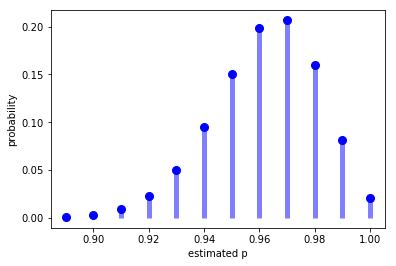

In [68]:
m.plot_basic(100)

In [69]:
def neighbourhood(machine, epsilon, p, n):
    return binom.cdf(p + epsilon, n, machine.p) - binom.cdf(p - epsilon, n, machine.p) ## Trash volgens mij ?

In [70]:
neighbourhood(m, 1, 97, 100)

0.3663444154979828

Idee van test_advanced: Interval rond \bar{p}, met bijvoorbeeld 97.5% kans dat echte p erin ligt. Hoe groter aantal tests n, hoe kleiner interval. Als het gehele interval boven 95% ligt, stop met testen, en het is een goede machine (met 97.5% zekerheid). Als het gehele interval onder 95% ligt, dan is het een slechte machine (met 97.5% zekerheid).

In [71]:
m.test_advanced(0.9, 10)

Left: 1.0
Right: 1.0


(1.0, 1)

In [73]:
m.calculate_interval(0.99, 10, 0.9)

(0.59999999999999998, 1.0)